In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
import keras
import nltk
import random
import plotly.express as px
import plotly.figure_factory as ff
import spacy

from plotly import graph_objs as go
from PIL import Image
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from collections import Counter , defaultdict
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint  , ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import Dense , LSTM ,Embedding , BatchNormalization ,Dropout ,Bidirectional , Flatten ,GlobalMaxPool1D
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score ,f1_score

In [14]:
data_path = '/content/drive/MyDrive/CODSOFT csv/spam.csv'

data =  pd.read_csv(data_path , encoding = 'latin')
data = data.drop(['Unnamed: 2' ,'Unnamed: 3' , 'Unnamed: 4'] , axis=1)
data.columns = ['Target', 'Message']
data.reset_index()
data.head()

,Target,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
data['message_length'] = data['Message'].apply(lambda x: len(x.split(" ")))
data.head()

,Target,Message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [16]:
data['Target'].value_counts()
Ham_len = data[data['Target']=='ham']['message_length'].value_counts().sort_index()
Spam_len= data[data['Target']=='spam']['message_length'].value_counts().sort_index()


fig = go.Figure()
fig.add_trace(go.Scatter(
    x = Ham_len.index ,
    y = Ham_len.values ,
    name= 'ham' ,
    fill= 'tozeroy',
    marker_color = 'darkslateblue',

    ))
fig.add_trace(go.Scatter(
    x = Spam_len.index ,
    y = Spam_len.values ,
    name = 'spam' ,
    fill = 'tozeroy',
    marker_color = 'darkorchid' ,
    ))

fig.update_layout( title = 'Distribution of Target')
fig.update_xaxes(range =[0,70])
fig.show()

In [17]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english') + ['u', 'im', 'c']
stemmer = nltk.SnowballStemmer('english')

def clean_text(text):
    '''Do lowercase, remove text in square brackets,links, punctuation
    and words containing numbers.'''
    text = str(text).lower()
    text = re.sub(' ', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def preprocessing(text):

    cleaned_text = clean_text(text)
    # remove stopwords
    cleaned_text  = ' '.join(word for word in cleaned_text.split(' ') if word not in stop_words)
    # do stem method
    cleaned_text  = ' '.join(stemmer.stem(word) for word in cleaned_text.split(' '))
    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
data['Cleaned_Message'] = data['Message'].apply(preprocessing)
# let's show new length after process

data['New_length'] = data['Cleaned_Message'].apply(lambda x: len(x.split(' ')))
data.head()

,Target,Message,message_length,Cleaned_Message,New_length
0,ham,"Go until jurong point, crazy.. Available only ...",20,gountiljurongpointcrazyavailableonlyinbugisngr...,1
1,ham,Ok lar... Joking wif u oni...,6,oklarjokingwifuoni,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,,1
3,ham,U dun say so early hor... U c already then say...,11,udunsaysoearlyhorucalreadythensay,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nahidontthinkhegoestousfhelivesaroundherethough,1


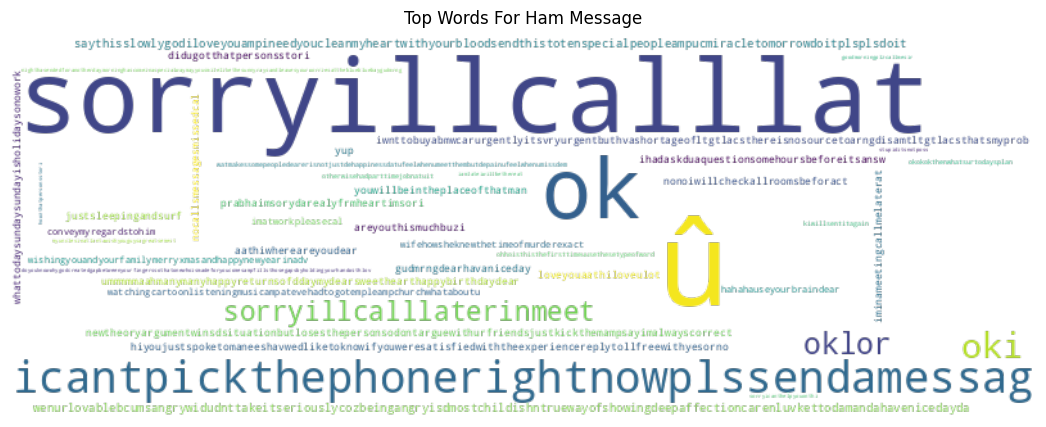

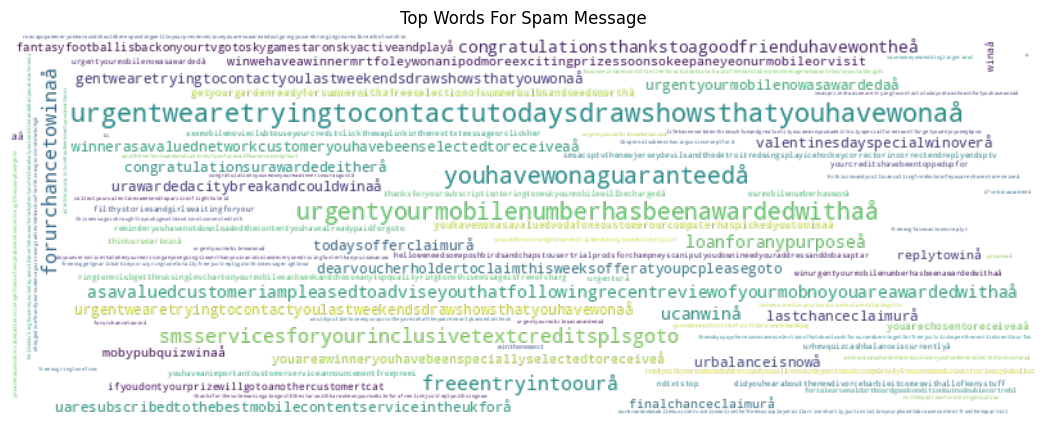

In [19]:
plt.figure(figsize = (16,5))
plt.title('Top Words For Ham Message')

Word_ham = WordCloud(
    background_color=None, mode="RGBA" ,
    width=800,
    height=300,
    )

Word_ham.generate(' '.join(text for text in  data.loc[ data['Target']=='ham' , 'Cleaned_Message']))
plt.imshow(Word_ham, interpolation='bilinear')
plt.axis('off')
plt.show()


plt.figure(figsize = (16,5))
plt.title('Top Words For Spam Message')

Word_spam = WordCloud(
    background_color=None, mode="RGBA" ,
    width=800,
    height=300,
    )

Word_spam.generate(' '.join(text for text in  data.loc[ data['Target']=='spam' , 'Cleaned_Message']))
plt.imshow(Word_spam, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
Encoder = LabelEncoder()

y_label   = Encoder.fit_transform(data['Target'])
train_data= data['Cleaned_Message']

X_train ,X_test , y_train , y_test = train_test_split(train_data , y_label , test_size=0.2 , random_state=42)

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer , CountVectorizer

TF_model = TfidfTransformer()
Vec_model= CountVectorizer()

Vec_model.fit(X_train)
X_train_vec = Vec_model.transform(X_train)
X_test_vec  = Vec_model.transform(X_test)

TF_model.fit(X_train_vec)
X_train_tfidf = TF_model.transform(X_train_vec)
X_test_tfidf  = TF_model.transform(X_test_vec)

X_train_tfidf

<4457x3214 sparse matrix of type '<class 'numpy.float64'>'
	with 3440 stored elements in Compressed Sparse Row format>

In [22]:
from sklearn.naive_bayes import MultinomialNB

NB_model = MultinomialNB()

# train the model
NB_model.fit(X_train_tfidf ,y_train)
NB_prediction = NB_model.predict(X_test_tfidf)

NB_confusion = confusion_matrix(NB_prediction , y_test)
NB_report    = classification_report(NB_prediction , y_test)
NB_accuracy  = accuracy_score(NB_prediction , y_test)

dash_line    = ' '.join('-' for _ in range(100))

print(f'Naive Bayes Confusion Matrix :\n{NB_confusion}')
print(dash_line)
print(f'Naive Bayes Classification Report :\n{NB_report}')
print(dash_line)
print(f'Naive Bayes Accuracy :\n{NB_accuracy}')

Naive Bayes Confusion Matrix :
[[965 144]
 [  0   6]]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Naive Bayes Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1109
           1       0.04      1.00      0.08         6

    accuracy                           0.87      1115
   macro avg       0.52      0.94      0.50      1115
weighted avg       0.99      0.87      0.93      1115

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Naive Bayes Accuracy :
0.8708520179372198
